# Search of branchpoint in all introns

In first notebook we chosen the best model for search branchpoints in introns. Now we want to find branch points in all introns. 

To do this, for the last 50 positions of each intron, we find the probability that each position is a branch point and choose the largest of them.
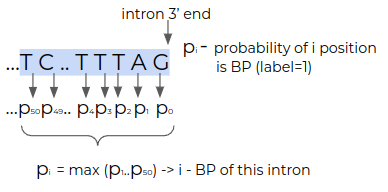

In [1]:
from Bio import SeqIO
from tqdm import tqdm
from collections import Counter
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils.random import sample_without_replacement
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier

# Initial data

In [2]:
#reference genome
hg19 = SeqIO.to_dict(SeqIO.parse("input data/hg19.fa", "fasta"))

In [3]:
#introns positions
introns = pd.read_csv('input data/ann_gencode_v19.bed', sep = '\t', header = None, names = ['chr', 'start', 'stop', 'ID', 'score', 'strand'])
introns = introns[introns['chr'].isin(hg19.keys())]
introns.drop('ID', inplace=True, axis=1)
introns = introns.drop_duplicates()

In [4]:
#high confidence banchpoints positions 
bp = pd.read_csv('input data/high_confidence_branchpoints.bed', sep = '\t', header = None, names = ['chr', 'start', 'stop', 'ID', 'score', 'strand'])

# Functions for model creation

In [5]:
def count_kmers(read, k):
    '''
    count k-mers distribution in read
    output: dictionary {k-mer:number of k-mer in this read}
    '''
    read = str(read).upper()
    counts = {}
    num_kmers = len(read) - k + 1
    for i in range(num_kmers):
        kmer = read[i:i+k]
        if 'N' in kmer: 
            continue
        if kmer not in counts:
            counts[kmer] = 0
        counts[kmer] += 1
    return counts

def kmers_pos(chrom, pos, n, k):
    '''
    count k-mers dist in (pos-n, pos+n)
    output: sorted by k-mer names disctionary {k-mer: number of k-mer in (pos-n, pos+n)}
    '''
    genom_chr = hg19[chrom]

    kmers = {}
    bp_round = genom_chr[pos-n:pos+n]
    cnt = count_kmers(bp_round.seq, k)

    kmers = Counter(cnt)
    kmers = dict(sorted(kmers.items()))
    
    return kmers

# Branchpoint detection (model validation)

Here we wanted to evaluate the reasonableness of the model. To do this, we compared high confidence branchpoints and those found by the model in same intron. We expected them to match.

In [58]:
chrom = 'chr1'
bp_chrom = bp[bp['chr']==chrom]
intron_chrom = introns[introns['chr']==chrom]

In [9]:
#find all introns in chromosome with high confidence BP
int_bp = pd.DataFrame(columns = ['chr', 'int_start', 'int_end', 'bp_start', 'bp_end', 'strand_int', 'strand_bp'])
for j in tqdm(range(len(bp_chrom))):
    cur_int = intron_chrom[(intron_chrom['start'] <= bp_chrom.iloc[j]['start']) & (bp_chrom.iloc[j]['stop'] <= intron_chrom['stop'])].iloc[-1]
    a = [chrom, cur_int['start'], cur_int['stop'], 
                     bp_chrom.iloc[j]['start'], bp_chrom.iloc[j]['stop'], 
                    cur_int['strand'], bp_chrom.iloc[j]['strand']]
    int_bp = int_bp.append({int_bp.columns[i]:a[i] for i in range(len(a))}, ignore_index = True)
int_bp = int_bp[int_bp['strand_int']== int_bp['strand_bp']]

100%|██████████| 7966/7966 [00:29<00:00, 270.93it/s]


In [10]:
int_bp

,chr,int_start,int_end,bp_start,bp_end,strand_int,strand_bp
0,chr1,91629,92090,91661,91662,-,-
1,chr1,705092,708355,705123,705124,-,-
2,chr1,708487,709550,708510,708511,-,-
3,chr1,764484,787306,784824,784825,+,+
4,chr1,787490,788050,788027,788028,+,+
...,...,...,...,...,...,...,...
7961,chr1,249151696,249151937,249151710,249151711,-,-
7962,chr1,249151696,249151937,249151717,249151718,-,-
7963,chr1,249151696,249151937,249151723,249151724,-,-
7964,chr1,249152058,249152329,249152081,249152082,-,-


# Search for branchpoints. Evaluation

In [7]:
n, k = 70, 5

In [8]:
X = np.load('Xy for training model (n=70, k=5)/X_70_5'+chrom+'.npy')
X = pd.DataFrame(X, columns = ['pos', *[''.join(i) for i in itertools.product('ATGC', repeat = 5)], 'dist3'])
y = np.load('Xy for training model (n=70, k=5)/y_70_5'+chrom+'.npy')

model = RandomForestClassifier()
model.fit(X, y)

RandomForestClassifier()

In [16]:
BP = pd.DataFrame(columns = [*int_bp.columns, 'BP'])

X_bp = pd.DataFrame(columns = [''.join(i) for i in itertools.product('ATGC', repeat = k)])
for i in tqdm(range(len(int_bp))):
    near_to_3 = []
    dist_to_3 = {}
    start, stop, strand = int_bp.iloc[i]['int_start'], int_bp.iloc[i]['int_end'], int_bp.iloc[i]['strand_int']
    for j in range(start, stop+1):
        if strand == '+': #start -> stop is 5' -> 3' 
            dist_to_3[j] = stop - j
            if stop - j <= 50:
                near_to_3.append(j)
        else:             #start -> stop is 3' -> 5' 
            dist_to_3[j] = j - start
            if stop - j <= 50:
                near_to_3.append(j)
            
    X_bp = pd.DataFrame(columns = [''.join(i) for i in itertools.product('ATGC', repeat = k)])
    for pos in near_to_3:
        X_bp = X_bp.append(kmers_pos(chrom, pos, n, k), ignore_index=True)
    X_bp.insert(loc=0, column='pos', value = near_to_3)
    X_bp = X_bp.fillna(0)
    X_bp['dist3'] = [dist_to_3[x] for x in X_bp['pos']]
    p_pred = model.predict_proba(X_bp)
    bp_cur = X_bp['pos'].iloc[np.where(p_pred[:, 1] == max(p_pred[:, 1]))[0][0]]
    row_cur = [*list(int_bp.iloc[i]), bp_cur]
    BP = BP.append({BP.columns[i]: row_cur[i] for i in range(8)}, ignore_index=True).drop_duplicates()

100%|██████████| 7941/7941 [16:59<00:00,  7.79it/s]


In [17]:
BP

,chr,int_start,int_end,bp_start,bp_end,strand_int,strand_bp,BP
0,chr1,91629,92090,91661,91662,-,-,92082
1,chr1,705092,708355,705123,705124,-,-,708317
2,chr1,708487,709550,708510,708511,-,-,709526
3,chr1,764484,787306,784824,784825,+,+,787301
4,chr1,787490,788050,788027,788028,+,+,788025
...,...,...,...,...,...,...,...,...
7936,chr1,249151696,249151937,249151710,249151711,-,-,249151924
7937,chr1,249151696,249151937,249151717,249151718,-,-,249151924
7938,chr1,249151696,249151937,249151723,249151724,-,-,249151924
7939,chr1,249152058,249152329,249152081,249152082,-,-,249152302


Text(0.5, 0, 'BP_ref-BP_found')

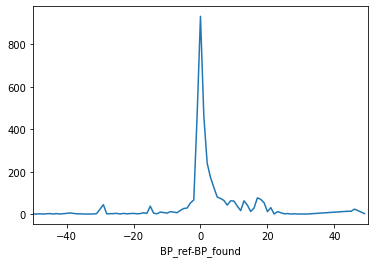

In [35]:
cnt =  dict(sorted(Counter(BP['bp_start']-BP['BP']).items()))
plt.plot(cnt.keys(), cnt.values())
plt.xlim(-50, 50)
plt.xlabel('BP_ref-BP_found')

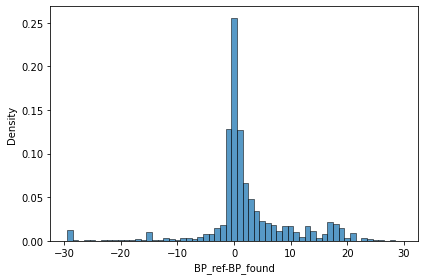

In [41]:
#plot hisogram
cnt = BP['bp_start']-BP['BP']
sns.histplot(cnt[abs(cnt) < 30], discrete = True, stat='density')
plt.xlabel('BP_ref-BP_found')
plt.tight_layout()

Thus, most often we hit exactly, and the spread is no more than 20 bases

# Probability of being BP for 3' end

In [15]:
near_to_3 = []
dist_to_3 = {}
i=0
start, stop, strand = intron_chrom.iloc[i]['start'], intron_chrom.iloc[i]['stop'], intron_chrom.iloc[i]['strand']
for j in range(start, stop+1):
    if strand == '+': #start -> stop is 5' -> 3' 
        dist_to_3[j] = stop - j
        if stop - j <= 50:
            near_to_3.append(j)
    else:             #start -> stop is 3' -> 5' 
        dist_to_3[j] = j - start
        if stop - j <= 50:
            near_to_3.append(j)

X_bp = pd.DataFrame(columns = [''.join(i) for i in itertools.product('ATGC', repeat = k)])
for pos in near_to_3:
    X_bp = X_bp.append(kmers_pos(chrom, pos, n, k), ignore_index=True)
X_bp.insert(loc=0, column='pos', value = near_to_3)
X_bp = X_bp.fillna(0)
X_bp['dist3'] = [dist_to_3[x] for x in X_bp['pos']]
p = model.predict_proba(X_bp)[:, 1]

Text(0, 0.5, 'p(label=1)')

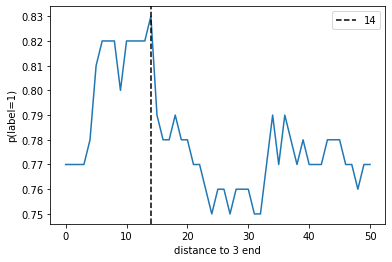

In [16]:
plt.plot(np.arange(len(p)), p)
bp_ = np.arange(len(p))[np.where(p == max(p))[0][0]]
plt.axvline(bp_, linestyle = '--', label = str(bp_), color = 'k')
plt.legend()
plt.xlabel('distance to 3 end')
plt.ylabel('p(label=1)')

So we see that there is a maximum which we call the branchpoint